<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Acá optimizo los pesos de una cartera buscando maximizar el ratio de Sharpe. Para esto primero hago una simulación de Monte Carlo con el fin de obtener un punto inicial favorable para hacer correr el modelo, obteniendo resultados prácticamente iguales debido a la simplicidad del problema.   
</p>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
sns.set_style('whitegrid')

In [2]:
tickers = ['AAPL', 'JPM', 'XOM', 'JNJ']
start_date = '2020-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
precios = yf.download(tickers, start=start_date, end=end_date)['Close']
retornos_log = np.log(precios / precios.shift(1)).dropna()
tnx_data = yf.Ticker('^TNX').history(period='5d')
risk_free_rate = tnx_data['Close'].iloc[-1] / 100
mu = retornos_log.mean() * 252
sigma_matrix = retornos_log.cov() * 252
print("\n--- Vector de Retornos Medios Anualizados (μ) ---")
print(mu)
print("\n--- Matriz de Covarianza Anualizada (Σ) ---")
print(sigma_matrix)

C:\Users\sebax\AppData\Local\Temp\ipykernel_11272\3671956929.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  precios = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed



--- Vector de Retornos Medios Anualizados (μ) ---
Ticker
AAPL    0.227047
JNJ     0.076762
JPM     0.168514
XOM     0.133401
dtype: float64

--- Matriz de Covarianza Anualizada (Σ) ---
Ticker      AAPL       JNJ       JPM       XOM
Ticker                                        
AAPL    0.102590  0.020821  0.043155  0.031710
JNJ     0.020821  0.038783  0.022787  0.018721
JPM     0.043155  0.022787  0.098886  0.058097
XOM     0.031710  0.018721  0.058097  0.109513


In [3]:
num_portafolios = 20000

# Arrays para guardar los resultados
resultados = np.zeros((3, num_portafolios)) # [Retorno, Volatilidad, Sharpe]
pesos_portafolios = []

for i in range(num_portafolios):
    pesos = np.random.rand(len(tickers))
    pesos /= np.sum(pesos)
    pesos_portafolios.append(pesos)
    
    # Retorno: E(Rp) = w^T * μ
    retorno_portafolio = np.dot(pesos, mu)
    # Volatilidad: σp = sqrt(w^T * Σ * w)
    volatilidad_portafolio = np.sqrt(np.dot(pesos.T, np.dot(sigma_matrix, pesos)))
    # Ratio de Sharpe
    sharpe_ratio = (retorno_portafolio - risk_free_rate) / volatilidad_portafolio

    resultados[0,i] = retorno_portafolio
    resultados[1,i] = volatilidad_portafolio
    resultados[2,i] = sharpe_ratio

resultados_df = pd.DataFrame(resultados.T, columns=['Retorno', 'Volatilidad', 'Sharpe'])

<p style="font-family:Times New Roman, serif; font-size:19px;text-align: justify">
Ahora con el algoritmo de Monte Carlo ya realizado para 20.000 simulaciones de pesos diferentes, se obtiene la combinación que tenga el máximo ratio de Sharpe, ya que es de los mejores indicadores para elegir una cartera debido a que nos podemos basar en su retorno y su volatilidad al mismo tiempo.
</p>

In [4]:
retorno_max_sharpe_C, vol_max_sharpe_C, max_sharpe_C = resultados_df.iloc[resultados_df['Sharpe'].idxmax()]
id_sharpe_S = resultados_df['Sharpe'].idxmax()
pesos_max_sharpe = pesos_portafolios[id_sharpe_S]
print(f"Índice Sharpe: {id_sharpe_S}")
print(f"Pesos encontrados Sharpe: {pesos_max_sharpe}")
print(f"Suma de pesos (debe ser 1): {np.sum(pesos_max_sharpe)}")

Índice Sharpe: 2715
Pesos encontrados Sharpe: [0.68788323 0.00256727 0.27058788 0.03896163]
Suma de pesos (debe ser 1): 1.0


In [5]:
retorno_min_vol_C, vol_min_vol_C, sharpe_min_vol_C = resultados_df.iloc[resultados_df['Volatilidad'].idxmin()]
id_vol = resultados_df['Volatilidad'].idxmin()
pesos_min_vol = pesos_portafolios[id_vol]
print(f"Índice Volatibilidad: {id_vol}")
print(f"Pesos encontrados Volatibilidad: {pesos_min_vol}")
print(f"Suma de pesos (debe ser 1): {np.sum(pesos_min_vol)}")

Índice Volatibilidad: 82
Pesos encontrados Volatibilidad: [0.1354123  0.68876311 0.05907332 0.11675126]
Suma de pesos (debe ser 1): 0.9999999999999999


<p style="font-family:Times New Roman, serif; font-size:19px;text-align:justify">
Con la mejor cartera definida por la simulación de Monte Carlo, ya se tiene un punto inicial de alto valor para realizar la optimización. Esta se hará con el método SLSQP tanto para encontrar la cartera con máximo ratio de Sharpe como para la que tenga mínima volatilidad.  
</p>

In [6]:
# --- A. Cartera de Máximo Ratio de Sharpe (Portafolio de Tangencia) ---
# Función a minimizar: el negativo del Ratio de Sharpe
def min_sharpe_ratio(pesos):
    retorno = np.dot(pesos, mu)
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(sigma_matrix, pesos)))
    sharpe = (retorno - risk_free_rate) / volatilidad
    return -sharpe # Minimizamos el negativo para maximizar el original

# Restricciones (constraints): la suma de los pesos debe ser 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Límites (bounds): cada peso debe estar entre 0 y 1 (sin posiciones cortas)
bounds = tuple((0, 1) for _ in range(len(tickers)))
# Peso inicial: Mejor opción Monte Carlo
initial_guess_S = pesos_max_sharpe
# Optimización
opt_sharpe = sco.minimize(min_sharpe_ratio, initial_guess_S, method='SLSQP', bounds=bounds, constraints=constraints)
# Pesos de la cartera de máximo Sharpe
pesos_max_sharpe = opt_sharpe.x

# --- B. Cartera de Mínima Volatilidad (Minimum Variance Portfolio) ---
# Función a minimizar: la volatilidad
def min_volatilidad(pesos):
    return np.sqrt(np.dot(pesos.T, np.dot(sigma_matrix, pesos)))
    
# Peso inicial: Mejor opción Monte Carlo   
initial_guess_V = pesos_min_vol
opt_vol = sco.minimize(min_volatilidad, initial_guess_V, method='SLSQP', bounds=bounds, constraints=constraints)
pesos_min_vol = opt_vol.x

In [7]:
retorno_max_sharpe = np.dot(pesos_max_sharpe, mu)
vol_max_sharpe = np.sqrt(np.dot(pesos_max_sharpe.T, np.dot(sigma_matrix, pesos_max_sharpe)))
sharpe_max = (retorno_max_sharpe - risk_free_rate) / vol_max_sharpe
print(sharpe_max)

0.6080760295662178


In [8]:
retorno_min_vol= np.dot(pesos_min_vol, mu)
vol_min_vol = np.sqrt(np.dot(pesos_min_vol.T, np.dot(sigma_matrix, pesos_min_vol)))
sharpe_min_vol = (retorno_min_vol - risk_free_rate) / vol_min_vol
print(vol_min_vol)

0.18257725054096866


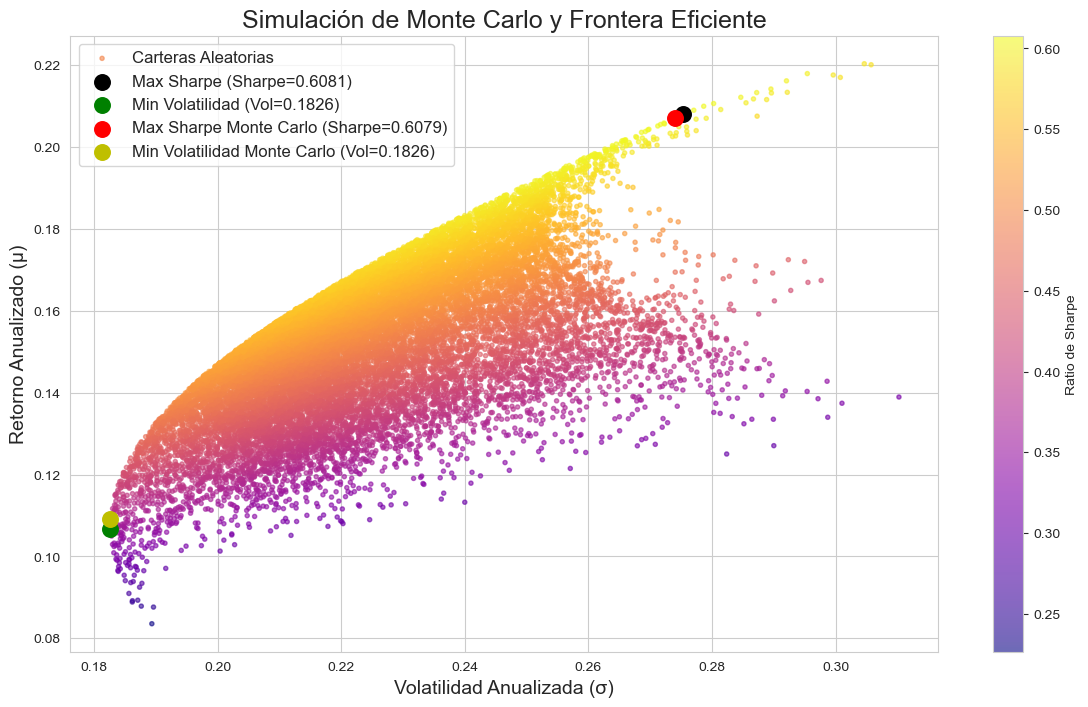


--- Cartera de Máximo Ratio de Sharpe ---
Pesos: {'AAPL': 0.7026, 'JPM': 0.0, 'XOM': 0.2518, 'JNJ': 0.0456}
Retorno: 20.80%, Volatilidad: 27.53%

--- Cartera de Mínima Volatilidad ---
Pesos: {'AAPL': 0.1226, 'JPM': 0.7046, 'XOM': 0.05, 'JNJ': 0.1228}
Retorno: 10.67%, Volatilidad: 18.26%


In [9]:
plt.figure(figsize=(14, 8))

# Graficar la nube de carteras aleatorias (coloreadas por el Ratio de Sharpe)
plt.scatter(resultados_df['Volatilidad'], resultados_df['Retorno'], c=resultados_df['Sharpe'], 
            marker='.', cmap='plasma', alpha=0.6, label='Carteras Aleatorias')
plt.colorbar(label='Ratio de Sharpe')

# Graficar las carteras óptimas
plt.scatter(vol_max_sharpe, retorno_max_sharpe, marker='.', color='black', s=500, 
            label=f'Max Sharpe (Sharpe={sharpe_max:.4f})')
plt.scatter(vol_min_vol, retorno_min_vol, marker='.', color='g', s=500, 
            label=f'Min Volatilidad (Vol={vol_min_vol:.4f})')
plt.scatter(vol_max_sharpe_C, retorno_max_sharpe_C, marker='.', color='r', s=500, 
            label=f'Max Sharpe Monte Carlo (Sharpe={max_sharpe_C:.4f})')
plt.scatter(vol_min_vol_C, retorno_min_vol_C, marker='.', color='y', s=500, 
            label=f'Min Volatilidad Monte Carlo (Vol={vol_min_vol_C:.4f})')


plt.title('Simulación de Monte Carlo y Frontera Eficiente', fontsize=18)
plt.xlabel('Volatilidad Anualizada (σ)', fontsize=14)
plt.ylabel('Retorno Anualizado (μ)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

print("\n--- Cartera de Máximo Ratio de Sharpe ---")
print(f"Pesos: {dict(zip(tickers, pesos_max_sharpe.round(4).tolist()))}")
print(f"Retorno: {retorno_max_sharpe:.2%}, Volatilidad: {vol_max_sharpe:.2%}")

print("\n--- Cartera de Mínima Volatilidad ---")
print(f"Pesos: {dict(zip(tickers, pesos_min_vol.round(4).tolist()))}")
print(f"Retorno: {retorno_min_vol:.2%}, Volatilidad: {vol_min_vol:.2%}")

<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Como se puede ver en el gráfico de dispersión, la optimización nos entregó una cartera con un ratio de Sharpe mejor al obtenido usando la simulación de Monte Carlo, pero no en gran magnitud, ya que debido a lo simple del problema la simulación logró aproximarse fuertemente a la mejor solución. Independiente de esto, es un mejor ratio y es claro que es buen método utilizar este tipo de simulaciones, mientras su uso sea factible, para poder encontrar un buen punto inicial.
</p>
<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Tras esto trazaremos la línea de asignación de capital, para ver las opciones que tendrían los distintos tipos de inversores si estuvieran analizando esta cartera, viendo si quieren invertir todo su dinero en riesgo o algún porcentaje en tasa libre de riesgo.
</p>

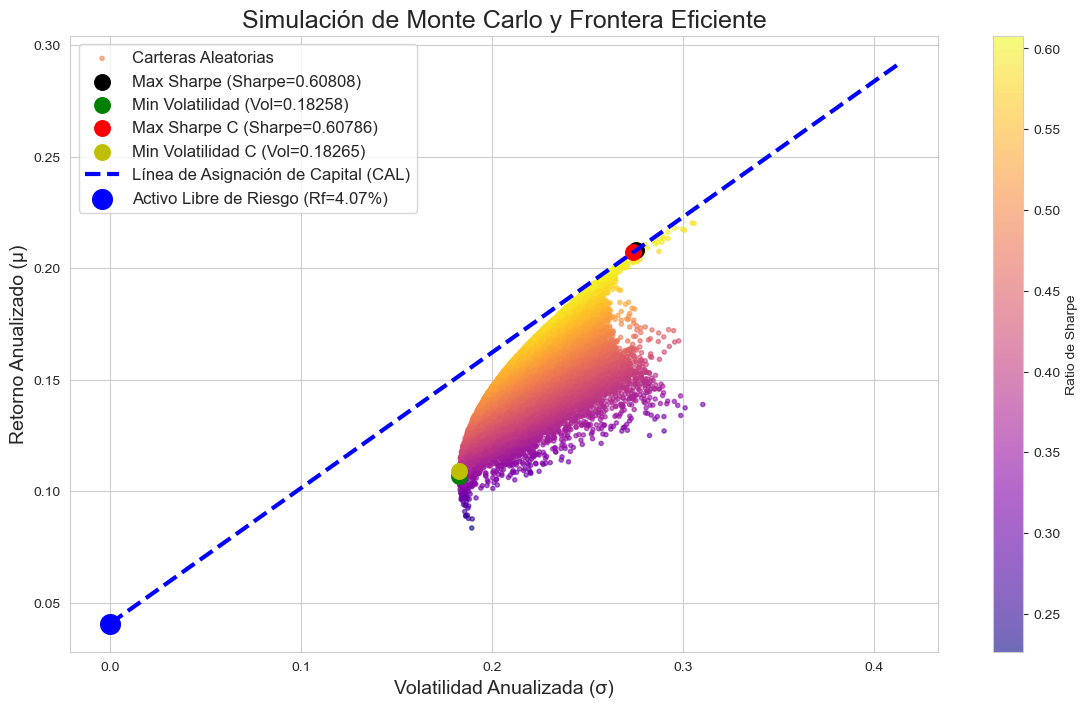

In [10]:
plt.figure(figsize=(14, 8))

# Graficar la nube de carteras aleatorias (coloreadas por el Ratio de Sharpe)
plt.scatter(resultados_df['Volatilidad'], resultados_df['Retorno'], c=resultados_df['Sharpe'], 
            marker='.', cmap='plasma', alpha=0.6, label='Carteras Aleatorias')
plt.colorbar(label='Ratio de Sharpe')

# Graficar las carteras óptimas
plt.scatter(vol_max_sharpe, retorno_max_sharpe, marker='.', color='black', s=500, 
            label=f'Max Sharpe (Sharpe={sharpe_max:.5f})')
plt.scatter(vol_min_vol, retorno_min_vol, marker='.', color='g', s=500, 
            label=f'Min Volatilidad (Vol={vol_min_vol:.5f})')
plt.scatter(vol_max_sharpe_C, retorno_max_sharpe_C, marker='.', color='r', s=500, 
            label=f'Max Sharpe C (Sharpe={max_sharpe_C:.5f})')
plt.scatter(vol_min_vol_C, retorno_min_vol_C, marker='.', color='y', s=500, 
            label=f'Min Volatilidad C (Vol={vol_min_vol_C:.5f})')

# Línea de Asignación de Capital (CAL)
cal_x = np.linspace(0, vol_max_sharpe * 1.5, 100) # Extender la línea más allá del punto de tangencia
cal_y = risk_free_rate + cal_x * sharpe_max
plt.plot(cal_x, cal_y, color='blue', linestyle='--', linewidth=3, 
         label='Línea de Asignación de Capital (CAL)')

# Añadir el punto de la Tasa Libre de Riesgo
plt.scatter(0, risk_free_rate, marker='o', color='blue', s=200, label=f'Activo Libre de Riesgo (Rf={risk_free_rate:.2%})')


plt.title('Simulación de Monte Carlo y Frontera Eficiente', fontsize=18)
plt.xlabel('Volatilidad Anualizada (σ)', fontsize=14)
plt.ylabel('Retorno Anualizado (μ)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()



<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Tras obtener la cartera con el máximo ratio de Sharpe y la línea de asignación de capital, a continuación simularé un módulo de asignación de capital para un cliente que busca invertir en esta cartera con riesgo, y el resto del porcentaje total de su presupuesto a tasa libre de riesgo.
</p>

In [11]:
#Decisión de Inversión
cantidad_total_a_invertir = 10000.0 # Mi capital total
porcentaje_en_riesgo = 0.4      # Mi decisión
porcentaje_en_bonos = 1.0 - porcentaje_en_riesgo # El 60% restante

# --- CÁLCULOS CARTERA PERSONAL ---
# Retorno Esperado (en Porcentaje)
retorno_esperado_pct = (porcentaje_en_bonos * risk_free_rate) + (porcentaje_en_riesgo * retorno_max_sharpe)
# Retorno Esperado (en Dinero)
retorno_esperado_dinero = cantidad_total_a_invertir * retorno_esperado_pct

# Volatilidad Esperada (Riesgo de mi cartera)
volatilidad_esperada_pct = porcentaje_en_riesgo * vol_max_sharpe

print(f"\n--- MI CARTERA PERSONAL ---")
print(f"Capital Total: ${cantidad_total_a_invertir:,.2f}")
print("-" * 30)
print(f"Asignación (Riesgo - MSR): {porcentaje_en_riesgo:.0%}")
print(f"Asignación (Bonos - Rf):   {porcentaje_en_bonos:.0%}")
print("-" * 30)
print(f"Retorno Esperado Anual (%): {retorno_esperado_pct:.2%}")
print(f"Retorno Esperado Anual ($): ${retorno_esperado_dinero:,.2f}")
print(f"Volatilidad Esperada (Anual): {volatilidad_esperada_pct:.2%}")


--- MI CARTERA PERSONAL ---
Capital Total: $10,000.00
------------------------------
Asignación (Riesgo - MSR): 40%
Asignación (Bonos - Rf):   60%
------------------------------
Retorno Esperado Anual (%): 10.76%
Retorno Esperado Anual ($): $1,076.06
Volatilidad Esperada (Anual): 11.01%
